In [47]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9,6
import seaborn as sns
import numpy as np

Импортируем данные

In [48]:
train=pd.read_excel('../SB_test/train.xlsx')
test=pd.read_excel('../SB_test/test.xlsx')

In [49]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


Бинаризуем целевую переменную

In [50]:
train['y']=train.y.apply(lambda x: 0 if x=='no' else 1)

Удаляем все строчки по которым есть неизвестные данные

In [51]:
train=train.replace('unknown', np.nan)
train=train.dropna()
test=test.replace('unknown', np.nan)
test=test.dropna()

In [52]:
del train['default']
del test['default']

Бинаризуем данные колонки, т.к. у них остаётся только по 2 значения

In [53]:
train['housing']=train.housing.apply(lambda x: 0 if x=='no' else 1)
train['loan']=train.loan.apply(lambda x: 0 if x=='no' else 1)
train['contact']=train.contact.astype('category').cat.codes

test['housing']=test.housing.apply(lambda x: 0 if x=='no' else 1)
test['loan']=test.loan.apply(lambda x: 0 if x=='no' else 1)
test['contact']=test.contact.astype('category').cat.codes

Переводим месяц и день в числовые значения

In [54]:
train['month']=train.month.astype('category').cat.codes
train['day_of_week']=train.day_of_week.astype('category').cat.codes

test['month']=test.month.astype('category').cat.codes
test['day_of_week']=test.day_of_week.astype('category').cat.codes

Все остальные фичи переводим в числовые значения

In [55]:
X_train=pd.get_dummies(train)
y_train=X_train['y']

X_test=pd.get_dummies(test)

In [56]:
del X_train['y']

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Разбиваем выборку для валидации

In [58]:
x_train, x_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Будем делать модель на нескольких алгоримах и в конце выберем лучший<br>
Набираем модели: возьмём, логРегрессию, Деревья ,Соседей, ГрадСпуск

In [59]:
lr=LogisticRegression
dtc=DecisionTreeClassifier
knn=KNeighborsClassifier
sgd=SGDClassifier

In [60]:
models={'lr':LogisticRegression,'dtc':DecisionTreeClassifier, 'knn':KNeighborsClassifier, 'sgd': SGDClassifier}

Набираем параметры для каждой модели

In [61]:
l1r=np.linspace(0,1,num=20)
grid4={
     'penalty':['none','l2', 'l1','elasticnet']
    ,'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron','squared_loss', 'huber', 'epsilon_insensitive','squared_epsilon_insensitive']
    ,'l1_ratio':l1r}
gs4=GridSearchCV(sgd(), grid4, scoring='accuracy', cv=5)
gs4.fit(x_train,y_train)
gs4.best_params_

{'l1_ratio': 0.73684210526315785, 'loss': 'modified_huber', 'penalty': 'none'}

In [62]:
cs=10**np.linspace(-3,1,5)
grid1={"C":cs, "penalty":['l1','l2'],'solver':['liblinear'], 'dual':[bool(0)]}
gs1=GridSearchCV(lr(),grid1,scoring='accuracy', cv=5)
gs1.fit(x_train,y_train)
gs1.best_params_

{'C': 0.01, 'dual': False, 'penalty': 'l2', 'solver': 'liblinear'}

In [63]:
grid2={
      'max_depth':list(range(1,20))
    , 'criterion':['gini','entropy']
    , 'splitter':['best','random']
    , 'class_weight':['balanced',None]}
gs2=GridSearchCV(DecisionTreeClassifier(), grid2, scoring='accuracy')
gs2.fit(x_train, y_train)
gs2.best_params_

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 4,
 'splitter': 'random'}

In [64]:
grid3={'n_neighbors':list(range(1,11)), 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'weights':['uniform','distance'], 'p':[1,2]}
gs3=GridSearchCV(knn(),grid3, scoring='accuracy')
gs3.fit(x_train,y_train)
gs3.best_params_

{'algorithm': 'auto', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}

Делаем цикл и итерируем по моделям с лучшими параметрами

In [65]:
score=[]
for x in models.values():
    if x==lr:
        grids=grid1
    elif x==dtc:
        grids=grid2
    elif x==knn:
        grids=grid3
    elif x==sgd:
        grids=grid4
    gs=GridSearchCV(x(), grids, scoring='accuracy')
    gs.fit(x_train,y_train)
    model=x(**gs.best_params_)
    model.fit(x_train,y_train)
    pred=model.predict(x_val)
    score.append(accuracy_score(y_val,pred ))
print(*(zip(score, models.keys())))

(0.88912133891213385, 'lr') (0.90585774058577406, 'dtc') (0.88284518828451886, 'knn') (0.87656903765690375, 'sgd')


Лучшая модель получилась на деревьях, её и берём, предсказываем и оцениваем на валидируещей выборке

In [98]:
clf=KNeighborsClassifier().fit(x_train,y_train)

In [99]:
pred=clf.predict(x_val)
pred_pr=clf.predict_proba(x_val)

In [100]:
print('Accuracy: {}'.format(accuracy_score(y_val, pred)))

Accuracy: 0.9016736401673641


In [101]:
print(classification_report(y_val,pred))

             precision    recall  f1-score   support

          0       0.92      0.98      0.94       411
          1       0.75      0.45      0.56        67

avg / total       0.89      0.90      0.89       478



In [102]:
print('ROC_AUC: {}'.format(roc_auc_score(y_val, pred)))

ROC_AUC: 0.711715146893271


In [103]:
fpr,tpr, _ = roc_curve(y_val, pred_pr[:,1])

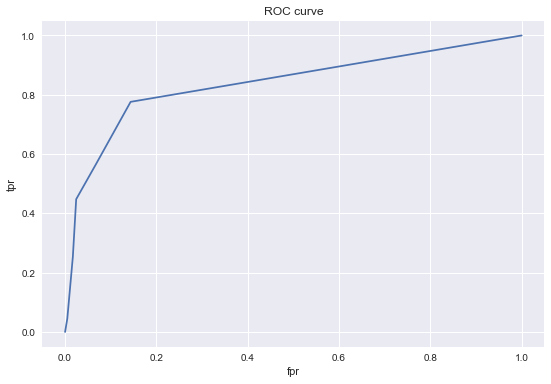

In [104]:
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve');

Делаем финальное предсказание на тестовых данных

In [ ]:
pred_final=clf.predict(X_test)